# Лабораторная работа 1 

выполнил студент группы М8О-201Б-20

Зайцев Кирилл Владимирович

Номер по списку: 7

Для начала подключим необходимые библиотеки Python: torch, matplotlib, numpy и sklearn. Затем зафиксируем сиды. После сосчитаем данные из файла, заведём переменные для параметров $\omega_1$ и $\omega_2$.
Сделаем из списков numpy тензоры pytorch.  

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

exercise_loss = 0.6073988487581576
w1, w2 = 0.6019925435133604, 0.5809652259444683

x_train = np.loadtxt("C:/test/vars_080522/train_x_7.csv")
y_train = np.loadtxt("C:/test/vars_080522/train_y_7.csv")
x_validation = np.loadtxt("C:/test/vars_080522/validation_x_7.csv")
y_validation = np.loadtxt("C:/test/vars_080522/validation_y_7.csv")

x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
x_validation = torch.from_numpy(x_validation.astype(np.float32))
y_validation = torch.from_numpy(y_validation.astype(np.float32))

Сделаем визуализацию данных

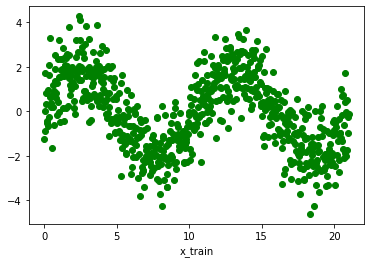

In [2]:
plt.scatter(x_train.data, y_train.data, c = 'green')
plt.xlabel("x_train")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

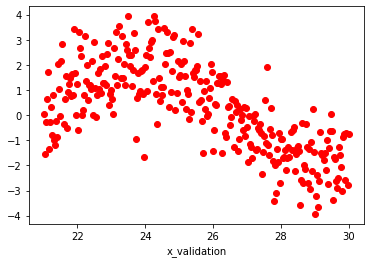

In [3]:
plt.scatter(x_validation.data, y_validation.data, c = 'red')
plt.xlabel("x_validation")
plt.show

Также для запуска сети с параметрами нам будут необходимы тензоры $[N, \; 4]$, поэтому сделаем копию данных

In [4]:
X2_train = torch.stack([x_train, torch.sin(x_train), torch.sin(w1 * x_train), torch.sin(w2 * x_train)])
X2_train = torch.transpose(X2_train, 0, 1)  
X2_validation = torch.stack([x_validation, torch.sin(x_validation), torch.sin(w1 * x_validation), 
                             torch.sin(w2 * x_validation)])
X2_validation = torch.transpose(X2_validation, 0, 1)

X3_train = torch.stack([x_train, torch.sin(x_train), torch.sin(w1 * x_train)])
X3_train = torch.transpose(X3_train, 0, 1)  
X3_validation = torch.stack([x_validation, torch.sin(x_validation), torch.sin(w1 * x_validation)])
X3_validation = torch.transpose(X3_validation, 0, 1)

X4_train = torch.stack([x_train, torch.sin(w1 * x_train), torch.sin(w2 * x_train)])
X4_train = torch.transpose(X4_train, 0, 1)  
X4_validation = torch.stack([x_validation, torch.sin(w1 * x_validation), torch.sin(w2 * x_validation)])
X4_validation = torch.transpose(X4_validation, 0, 1)

X5_train = torch.stack([torch.sin(w1 * x_train), torch.sin(w2 * x_train)])
X5_train = torch.transpose(X5_train, 0, 1)  
X5_validation = torch.stack([torch.sin(w1 * x_validation), torch.sin(w2 * x_validation)])
X5_validation = torch.transpose(X5_validation, 0, 1)

X6_train = torch.stack([x_train, torch.sin(x_train), torch.sin(w2 * x_train)])
X6_train = torch.transpose(X6_train, 0, 1)  
X6_validation = torch.stack([x_validation, torch.sin(x_validation), torch.sin(w2 * x_validation)])
X6_validation = torch.transpose(X6_validation, 0, 1)

In [5]:
x_train = x_train.unsqueeze(1).float()
y_train = y_train.unsqueeze(1).float()
x_validation = x_validation.unsqueeze(1).float()
y_validation = y_validation.unsqueeze(1).float()

Напишем самую простую сеть, в которой будет всего один параметр $x_0$, сеть будет иметь $N_{neurons}$ нейронов, функцией активации будем использовать самую простую сигмоиду.

## Сеть с одним слоем

In [6]:
class NonParam_Regression(torch.nn.Module):
    def __init__(self, n_neurons):
        super(NonParam_Regression, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_neurons)
        self.activ1 = torch.nn.Tanh()
        self.fc2 = torch.nn.Linear(n_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        return x

Функция, которая отобразит полученные предсказания

In [7]:
def predict(net, x, y):
    y_pred = net.forward(x)
    
    plt.plot(x.cpu(), y.cpu(), 'o', label='Истинные данные')
    plt.plot(x.cpu(), y_pred.cpu().data.numpy(), c='r', linewidth = 5, label='Предсказание');
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
    print('loss (r2_score):', sklearn.metrics.r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy()))

In [8]:
model = NonParam_Regression(50)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.MSELoss()

Функция тренировки сети:

In [10]:
batch_size = 100
def train(model, x_train, y_train, x_validation, y_validation, epoches):
    train_loss_val = []
    test_loss_val = []
    for epoch in range(epoches):
        order = np.random.permutation(len(x_train))
        for start_index in range(0, len(x_train), batch_size):
        
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index + batch_size]
            x_batch = torch.FloatTensor(x_train[batch_indexes])
            y_batch = y_train[batch_indexes]
            preds = model.forward(x_batch)
            loss_val = loss(preds, y_batch)
            loss_val.backward()
            optimizer.step()
        if (epoch % 2 == 0):
            train_loss_val.append(sklearn.metrics.r2_score(y_batch.cpu().detach().numpy(), preds.cpu().detach().numpy()))    
            test_preds = model.forward(x_validation)
            test_loss_val.append(sklearn.metrics.r2_score(y_validation.cpu().detach().numpy(),
                                                          test_preds.cpu().detach().numpy()))
        if (epoch % 10000 == 0):
            print(epoch)
    plt.plot(train_loss_val, 'r', label = 'train')
    plt.plot(test_loss_val, 'k', label = 'test')
    plt.xlabel("r2_score")
    plt.ylim (0, 1)
    plt.legend() 


0


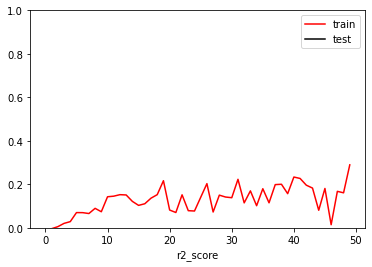

In [11]:
train(model, x_train, y_train, x_validation, y_validation, 100)

Предсказание для тренировочных данных

loss (r2_score): 0.17766738761700185


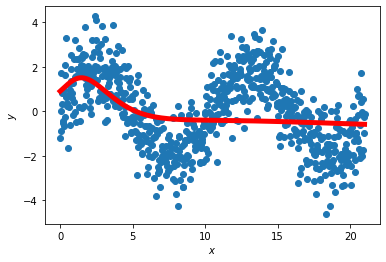

In [12]:
predict(model, x_train, y_train)

Предсказание для валидационных данных

loss (r2_score): -0.27143380538900286


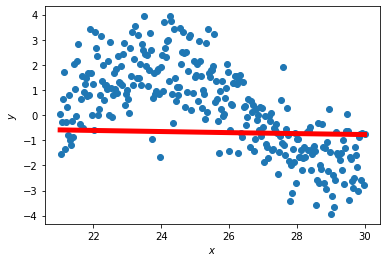

In [13]:
predict(model, x_validation, y_validation)

## Сеть с несколькими признаками

In [14]:
class Param_Regression(torch.nn.Module):
    def __init__(self, n_params, n_neurons):
        super(Param_Regression, self).__init__()
        self.fc1 = torch.nn.Linear(n_params, n_neurons)
        self.activ1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_neurons, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        return x

In [15]:
model2 = Param_Regression(4, 50)

0


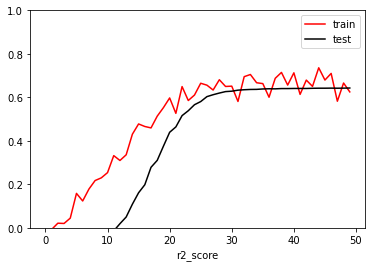

In [16]:
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
train_loss_val = []
test_loss_val = []
train(model2, X2_train, y_train, X2_validation, y_validation, 100)

In [17]:
def predict2(net, x, y): 
    y_pred = net.forward(x)
    plt.plot(x[:, 0].cpu(), y.cpu(), 'o', label='Истинные данные') 
    plt.plot(x[:, 0].cpu(), y_pred.cpu().data.numpy(), c='r', linewidth = 5, label='Предсказание');
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    
    print('loss (r2_score):', sklearn.metrics.r2_score(y.cpu().detach().numpy(), y_pred.cpu().detach().numpy()))

Предсказание сети с несколькими параметрами: синим цветом обозначены тренировочные данные, оранжевым --- тестовые

loss (r2_score): 0.6532579649734676
loss (r2_score): 0.6432997485736331


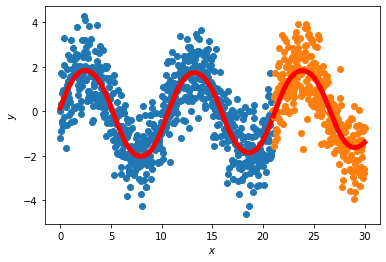

In [18]:
predict2(model2, X2_train, y_train)
predict2(model2, X2_validation, y_validation)

Сеть с 3 признаками $x_0, sin(x_0), sin(\omega_1 * x_0)$

In [19]:
net3par = Param_Regression(3, 50)

0


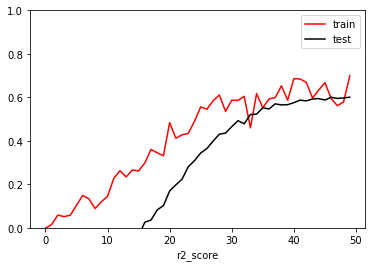

In [20]:
optimizer = torch.optim.Adam(net3par.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
train(net3par, X3_train, y_train, X3_validation, y_validation, 100)

Предсказание для сети с параметрами $x_0, sin(x_0), sin(\omega_1 * x_0)$

loss (r2_score): 0.6467192767006624
loss (r2_score): 0.5911782475510734


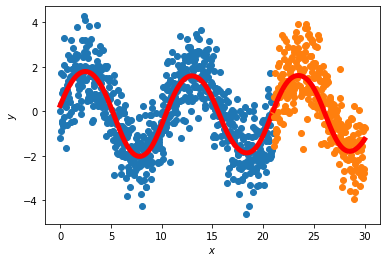

In [21]:
predict2(net3par, X3_train, y_train)
predict2(net3par, X3_validation, y_validation)

Сеть с 3 параметрами $x_0, sin(\omega_1 \cdot x_0), sin(\omega_2 \cdot x_0)$

In [22]:
other_net3par = Param_Regression(3, 50)

0


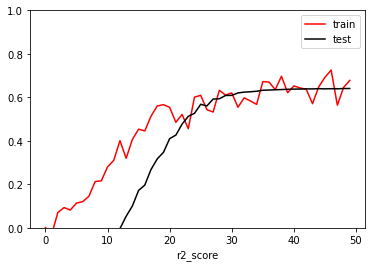

In [23]:
optimizer = torch.optim.Adam(other_net3par.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
train(other_net3par, X4_train, y_train, X4_validation, y_validation, 100)

Предсказание для сети с 3 параметрами:

loss (r2_score): 0.652350689907234
loss (r2_score): 0.6404488966348558


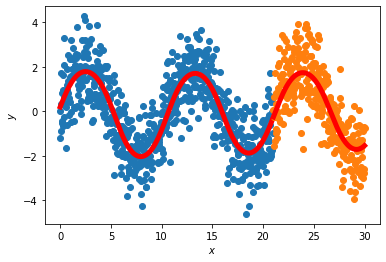

In [24]:
predict2(other_net3par, X4_train, y_train)
predict2(other_net3par, X4_validation, y_validation)

Сеть с 2 параметрами $sin(\omega_1 * x_0), sin(\omega_2 * x_0)$

In [25]:
net2par = Param_Regression(2, 50)

0


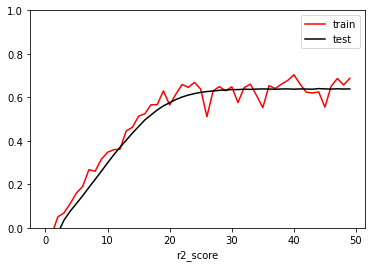

In [26]:
optimizer = torch.optim.Adam(net2par.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
train(net2par, X5_train, y_train, X5_validation, y_validation, 100)

loss (r2_score): 0.651914240971444
loss (r2_score): 0.6402526172346259


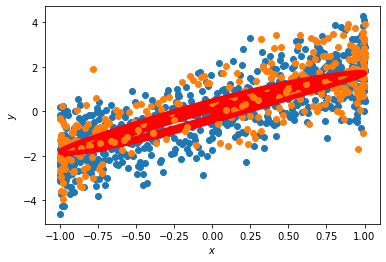

In [27]:
predict2(net2par, X5_train, y_train)
predict2(net2par, X5_validation, y_validation)

Сеть с 3 параметрами $x_0, sin(x_0), sin(\omega_2 \cdot x_0)$

In [28]:
another_net3par = Param_Regression(3, 50)

0


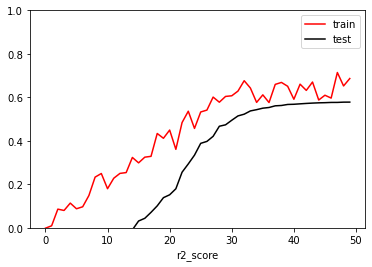

In [29]:
optimizer = torch.optim.Adam(another_net3par.parameters(), lr=0.001)
loss = torch.nn.MSELoss()
train(another_net3par, X6_train, y_train, X6_validation, y_validation, 100)

loss (r2_score): 0.6378013030972909
loss (r2_score): 0.5794205585307661


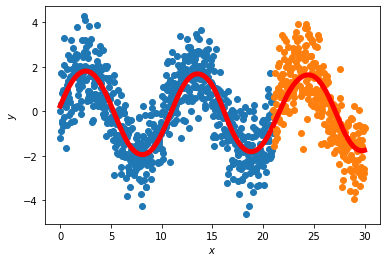

In [30]:
predict2(another_net3par, X6_train, y_train)
predict2(another_net3par, X6_validation, y_validation)

# Вывод 

В ходе работы мною была решена задача регрессии с помощью нейронных сетей. Сперва я создал сеть с одним признаком на вход, которая обучалась очень плохо, и на тренировочном датасете значение r2_score было отрицательным. Сеть переобучалась очень быстро. Позже мною были добавлены признаки, для них я написал отдельную сеть, которая обучалась быстрее, а показатель r2_score был близок к тому, с которым его нужно было сравнить по заданию 

Также было установлено, что можно отбросить любой из признаков $sin(\omega_1 \cdot x_0)$ и $sin(\omega_2 \cdot x_0)$, а также сам $x_0$ и $sin(x_0)$

In [ ]:
При этом наилучшая т